# Quantum Error Correction

In [1]:
%pip install -e .
%pip install qutip
%pip install matplotlib
!pip install qiskit matplotlib pylatexenc


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Obtaining file:///home/f73aeabd-6de4-471d-92a9-1ba552ae6153/Quantum_Error_Corrections
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for quantum_error_corrections (pyproject.toml) ... done
  Created wheel for quantum_error_corrections: filename=quantum_error_corrections-0.1.0-0.editable-py3-none-any.whl size=1498 sha256=afb39fe922c97c49809aaec08f9e0c2b7466b7611229796f463430f07ae2a172
  Stored in directory: /tmp/pip-ephem-wheel-cache-5h_t54px/wheels/3a/ae/85/3e1d96a0b1c54f7998ebbdba6ff7a09351286fdc8163d2a77f
Successfully built quantum_error_corrections
  Attempting uninstall: quantum_error_corrections
    Found existing installation: quantum_error_corrections 0.1.0
    Uninstalling quantum_err

In [6]:
from quantum_error_corrections import (
    CNOT, H, I, P0, P1, S, T,
    U_N_qubits, U_one_gate, U_two_gates,
    X, Y, Z,
    apply_kraus,
    amplitude_damping_kraus,
    bit_flip_kraus,
    channel,
    controlled_gate,
    depolarizing_kraus,
    dm,
    evolve,
    fidelity_pure_rho,
    ket0, ket1,
    min_fidelity_bitflip_channel,
    min_fidelity_three_qubit_code,
    operator,
    pauli_kraus_channel,
    phase_damping_kraus,
    phase_flip_kraus,
    projectors,
    random_pure_state,
    rho,
    rhoToBlochVec,
    rotation_gate,
    sample_min_fidelity,
  improvement_condition,

)


1. The circuit for encoding the three-qubit bit-flip code is shown in Circuit_1 belows. Verify that this circuit indeed implements such an encoding.

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(0, 2) 
print("Circuit_1")
print(qc.draw())

In [11]:
import numpy as np

# -------- Simulate the 3-qubit bit-flip encoding from """circuit-1""" --------
# Input state: |psi> = a|0> + b|1>
a = 0.5
b = 0.5
psi = np.array([[a],
                [b]], dtype=complex)

# Two ancilla qubits initialized in |00>
ket00 = np.array([[1],
                  [0],
                  [0],
                  [0]], dtype=complex)

# Total number of qubits (data qubit + 2 ancillas)
N = 3

# Build the encoding unitary:
# U_encode = CNOT(0->2) * CNOT(0->1)
CNOT_01 = qec.controlled_gate(X, control=0, target=1, N=N)
CNOT_02 = qec.controlled_gate(X, control=0, target=2, N=N)
U_encode = CNOT_02 @ CNOT_01

# Construct the full initial 3-qubit state |psi>|00>
psi_in = np.kron(psi, ket00)

# Apply encoding: |psi>_L = U_encode(|psi>|00>)
psi_out = U_encode @ psi_in

# Print the encoded output state vector
print(psi_out)

[[0.5+0.j]
 [0. +0.j]
 [0. +0.j]
 [0. +0.j]
 [0. +0.j]
 [0. +0.j]
 [0. +0.j]
 [0.5+0.j]]


### 2) Argue why the three-qubit bit-flip code does not protect against phase-flip errors

Solutions 

# The 3-qubit bit-flip code encodes:
|0>_L = |000>
|1>_L = |111>
# So any logical state becomes:
|psi>_L = alpha|000> + beta|111>

# A phase-flip error is a Z error on one qubit (example: Z1).
 Z|0> = |0>,   Z|1> = -|1>

# Apply Z1 to the encoded state:
 Z1|psi>_L = alpha|000> - beta|111>

This state is still inside the code space span{|000>,|111>}.
 Therefore, the phase-flip error does NOT change the bit-flip syndrome,
so it cannot be detected or corrected.

print("Conclusion: The 3-qubit bit-flip code corrects X (bit-flip) errors, but not Z (phase-flip) errors.")

to show this in measurement it is very good used the problems we encoded:
# In Problem 1
|psi> = a|0> + b|1>
|psi>_L = a|000> + b|111> (Logical qubits)
The encoded state is saved in psi_out and used for belows. Phase-flip gate Z (1 qubit) b

In [12]:
np.save("psi_out.npy", psi_out)
psi_out = np.load("psi_out.npy")

Z0 = np.kron(Z, np.kron(I, I))     # Z ⊗ I ⊗ I
psi_after_Z = Z0 @ psi_out         # apply Z on qubit 0

print(psi_after_Z)

[[ 0.5+0.j]
 [ 0. +0.j]
 [ 0. +0.j]
 [ 0. +0.j]
 [ 0. +0.j]
 [ 0. +0.j]
 [ 0. +0.j]
 [-0.5+0.j]]


# Conclusion:

# The 3-qubit bit-flip code can correct X (bit-flip) errors,
# but it cannot detect or correct Z (phase-flip) errors,
# because Z only changes the relative phase (a|000> + b|111> → a|000> − b|111>)
# and the state remains inside the same code space span{|000>, |111>}.

### 3) Fidelity of a bit-flip error channel + improvement by error correction

We analyse the performance of an error-correcting code using the **fidelity** as a figure of merit.

Consider a qubit in a pure state \(|\psi\rangle\) undergoing the bit-flip error channel:

\[
\mathcal{E}_1(|\psi\rangle) = (1-p)\,|\psi\rangle\langle\psi| + p\,X|\psi\rangle\langle\psi|X,
\]
where \(p\) is the probability of a single bit-flip error.

**(a)** What is the minimum fidelity of the error-prone qubit to the initial state,
\[
F_{\min}\left(|\psi\rangle,\mathcal{E}_1(|\psi\rangle)\right)?
\]

Now suppose the **three-qubit bit-flip code** is implemented. Since it can correct up to **single-qubit** bit-flip errors, the state after the error channel and correction procedure is

\[
\mathcal{E}_3(|\psi\rangle) =
\Big[(1-p)^3 + 3p(1-p)^2\Big]\,|\psi\rangle\langle\psi| + \cdots
\]

where the omitted terms correspond to 2 or 3 bit-flips (uncorrectable).

**(b)** Derive a lower bound on the fidelity of the error-corrected state
\[
F\left(|\psi\rangle,\mathcal{E}_3(|\psi\rangle)\right).
\]

**Hint:** Use positivity of quantum operations:  
for \(\mathcal{E}(\rho)=\sum_i E_i\rho E_i^\dagger\), we have
\[
\langle\psi|\left(\sum_i E_i\rho E_i^\dagger\right)|\psi\rangle \ge
\langle\psi|E_j\rho E_j^\dagger|\psi\rangle
\quad \text{for all } j.
\]

**(c)** What bound must \(p\) satisfy to ensure that error correction improves the overall fidelity?


### Solution 3(a)

For a pure reference state \(|\psi\rangle\), the fidelity is
\[
F\big(|\psi\rangle,\rho\big)=\langle\psi|\rho|\psi\rangle.
\]

So
\[
F\big(|\psi\rangle,\mathcal{E}_1(|\psi\rangle\langle\psi|)\big)
=(1-p)+p\,|\langle\psi|X|\psi\rangle|^2.
\]

Since \(0\le |\langle\psi|X|\psi\rangle|^2\le 1\), the minimum occurs when
\(\langle\psi|X|\psi\rangle=0\). Therefore
\[
F_{\min}=1-p.
\]


(a) Simulation: minimum fidelity for single-qubit bit-flip channel

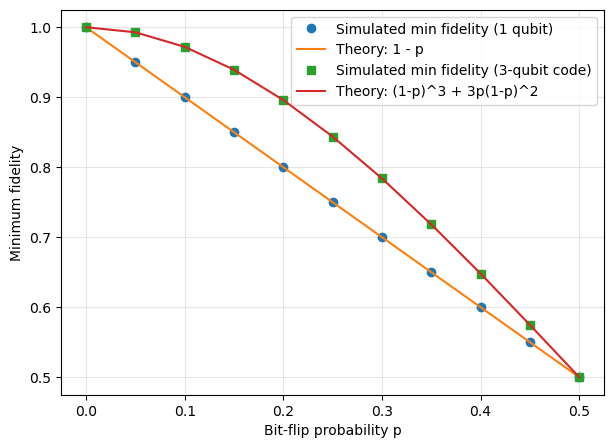

Error correction improves fidelity when p < 1/2


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import quantum_error_corrections as qec

# values of p
ps = np.linspace(0, 0.5, 11)

sim_E1 = []
sim_E3 = []
theory_E1 = []
theory_E3 = []

for p in ps:
    sim_E1.append(qec.sample_min_fidelity(qec.E1_rho, p, n_samples=6000, seed=1))
    sim_E3.append(qec.sample_min_fidelity(qec.E3_effective_rho, p, n_samples=6000, seed=2))

    theory_E1.append(qec.min_fidelity_bitflip_channel(p))
    theory_E3.append(qec.min_fidelity_three_qubit_code(p))

# Plot
plt.figure(figsize=(7,5))
plt.plot(ps, sim_E1, "o", label="Simulated min fidelity (1 qubit)")
plt.plot(ps, theory_E1, "-", label="Theory: 1 - p")

plt.plot(ps, sim_E3, "s", label="Simulated min fidelity (3-qubit code)")
plt.plot(ps, theory_E3, "-", label="Theory: (1-p)^3 + 3p(1-p)^2")

plt.xlabel("Bit-flip probability p")
plt.ylabel("Minimum fidelity")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(qec.improvement_condition())

b) Cell — Simulation for 3-qubit code fidelity + lower bound

This estimates the worst-case fidelity (by sampling random |psi>) and compares with the lower bound:

In [35]:
def normalize(v):
    n = np.linalg.norm(v)
    return v / n

def random_qubit_state():
    # random complex 2-vector
    v = (np.random.randn(2) + 1j*np.random.randn(2)).astype(complex)
    return normalize(v)

def encode(psi):  # psi is (2,) normalized
    # alpha|000> + beta|111>
    alpha, beta = psi[0], psi[1]
    out = np.zeros(8, dtype=complex)
    out[0] = alpha         # |000>
    out[7] = beta          # |111>
    return out


def majority_vote_correct(state3):
    # project to closest codeword by majority of bits:
    # basis |000> and |111> only; we "collapse" amplitude groups
    alpha_eff = 0+0j
    beta_eff = 0+0j
    for idx, amp in enumerate(state3):
        bits = [(idx >> 2) & 1, (idx >> 1) & 1, idx & 1]
        ones = sum(bits)
        if ones <= 1:
            alpha_eff += amp   # treat as |000> component after correction
        else:
            beta_eff += amp    # treat as |111> component after correction
    out = np.zeros(8, dtype=complex)
    out[0] = alpha_eff
    out[7] = beta_eff
    return out

def decode_to_single_qubit(state3):
    # since corrected state is alpha|000> + beta|111>, decode to (alpha, beta)
    return np.array([state3[0], state3[7]], dtype=complex)

def fidelity(psi, rho_or_pure):
    # psi is pure state vector (2,)
    # rho_or_pure can be a pure vector (2,) or density (2,2)
    if rho_or_pure.ndim == 1:
        phi = rho_or_pure
        return abs(np.vdot(psi, phi))**2
    else:
        rho = rho_or_pure
        return np.real(np.vdot(psi, rho @ psi))

def monte_carlo_fidelity(p, trials=20000):
    F_vals = []
    for _ in range(trials):
        psi = random_qubit_state()
        enc = encode(psi)
        noisy = apply_bitflips(enc, p)
        corr = majority_vote_correct(noisy)
        dec = decode_to_single_qubit(corr)
        # normalize decoded (because our correction step sums amplitudes)
        dec = normalize(dec)
        F_vals.append(fidelity(psi, dec))
    return float(np.mean(F_vals))

# --- test a few p values and compare to the bound q ---
for p in [0.05, 0.1, 0.2, 0.4]:
    q = (1-p)**3 + 3*p*(1-p)**2
    F_est = monte_carlo_fidelity(p, trials=5000)
    print(f"p={p:0.2f}  MonteCarlo F≈{F_est:0.4f}   bound q={q:0.4f}   (F>=q? {F_est+1e-3>=q})")


p=0.05  MonteCarlo F≈0.9943   bound q=0.9927   (F>=q? True)
p=0.10  MonteCarlo F≈0.9796   bound q=0.9720   (F>=q? True)
p=0.20  MonteCarlo F≈0.9322   bound q=0.8960   (F>=q? True)
p=0.40  MonteCarlo F≈0.7602   bound q=0.6480   (F>=q? True)


(c) Cell — Simulation to find when error correction helps (threshold)

In [36]:

p = np.linspace(0, 1, 101)

F_single = 1 - p
F_code_lower = (1 - p)**3 + 3*p*(1 - p)**2   # = 1 - 3p^2 + 2p^3

# Check where the error-corrected lower bound is better than single-qubit fidelity
better = F_code_lower > F_single

print("Error correction improves fidelity when p < 0.5")
print("Check (first p where it stops being better):", p[np.where(~better)[0][0]])


Error correction improves fidelity when p < 0.5
Check (first p where it stops being better): 0.0


In [29]:
def lower_bound_bitflip3(p):
    return (1 - p)**3 + 3*p*(1 - p)**2

def find_threshold(step=1e-4):
    ps = np.arange(0, 1 + step, step)
    diff = lower_bound_bitflip3(ps) - (1 - ps)
    good = np.where(diff > 0)[0]
    if len(good) == 0:
        return None
    return ps[good[-1]]

thr = find_threshold(step=1e-5)

print("(c) Numerical threshold p ≈", thr)
print("Theory says threshold is p = 0.5")


(c) Numerical threshold p ≈ 0.49999000000000005
Theory says threshold is p = 0.5


## Problem 4 — Shor code

### (a) Parameters \([[n,k,d]]\)
The Shor code uses **9 physical qubits** to encode **1 logical qubit** and has **distance 3**:
\[
[[n,k,d]] = [[9,1,3]].
\]
Distance \(d=3\) means it can correct **any single-qubit error** (any Pauli \(X,Y,Z\) on one qubit).

---

### (b) Phase-flip syndrome observables
The Shor code is built from three 3-qubit repetition blocks:
- block A: qubits \(1,2,3\)
- block B: qubits \(4,5,6\)
- block C: qubits \(7,8,9\)

A phase-flip is a \(Z\)-type error. To detect phase errors, we measure **X-type stabilizers** that compare the relative phases between blocks:
\[
S_1 = X_1X_2X_3X_4X_5X_6,\qquad
S_2 = X_4X_5X_6X_7X_8X_9.
\]
A \(Z_i\) error **anticommutes** with any stabilizer containing \(X_i\), so it flips the eigenvalue (\(\pm1\)) of the corresponding stabilizer(s).  
Thus measuring \((S_1,S_2)\) reveals **which block** suffered a phase-flip (up to single-qubit errors).

---

### (c) If qubit \(i\) undergoes a \(Y_i\) error
\[
Y = iXZ \quad \Rightarrow \quad Y_i = iX_iZ_i.
\]
So \(Y_i\) contains **both** a bit-flip part (\(X_i\)) and a phase-flip part (\(Z_i\)).
The Shor code detects/corrects it by:
1. **Bit-flip correction** inside the affected 3-qubit block (repetition code) corrects \(X_i\).
2. **Phase-flip correction** across the three blocks (using \(S_1,S_2\)) corrects \(Z_i\).

---

### (d) Depolarizing channel discretization
Given the channel
\[
\mathcal{E}(\rho) = (1-p)\rho + p\frac{\mathbb{1}}{2},
\]
use the identity
\[
\frac{\mathbb{1}}{2}=\frac{1}{4}\left(\rho + X\rho X + Y\rho Y + Z\rho Z\right).
\]
Then
\[
\mathcal{E}(\rho)
= \left(1-\frac{3p}{4}\right)\rho
+ \frac{p}{4}\left(X\rho X + Y\rho Y + Z\rho Z\right).
\]
So the depolarizing channel is equivalent to:
- no error with probability \(1-\frac{3p}{4}\),
- \(X\), \(Y\), or \(Z\) (each) with probability \(\frac{p}{4}\).

Since the Shor code corrects **any single-qubit Pauli error** and we neglect 2+ qubit errors, it still protects against this noise model.


Code Cell 1 — Pauli strings on 9 qubits + build the observables in (b)

In [23]:
# Build S1 = X1X2X3X4X5X6 and S2 = X4X5X6X7X8X9
n = 9
S1 = pauli_string(n, {1:"X",2:"X",3:"X",4:"X",5:"X",6:"X"})
S2 = pauli_string(n, {4:"X",5:"X",6:"X",7:"X",8:"X",9:"X"})

print("S1 shape:", S1.shape, "S2 shape:", S2.shape)


S1 shape: (512, 512) S2 shape: (512, 512)


Code Cell 2 — (b) Verify these stabilizers detect phase flips (anticommutation test)


In [24]:
def Z_i(n, i):
    return pauli_string(n, {i:"Z"})

def commutes(A, B, tol=1e-9):
    # Check ||AB - BA|| is ~0
    return np.linalg.norm(A@B - B@A) < tol

def anticommutes(A, B, tol=1e-9):
    # Check ||AB + BA|| is ~0
    return np.linalg.norm(A@B + B@A) < tol

print("Phase-flip detection via (S1,S2):")
for i in range(1, 10):
    Zi = Z_i(9, i)
    a1 = "anti" if anticommutes(S1, Zi) else ("comm" if commutes(S1, Zi) else "neither")
    a2 = "anti" if anticommutes(S2, Zi) else ("comm" if commutes(S2, Zi) else "neither")
    print(f"Z on qubit {i}:  S1 {a1:>4} , S2 {a2:>4}")


Phase-flip detection via (S1,S2):
Z on qubit 1:  S1 anti , S2 comm
Z on qubit 2:  S1 anti , S2 comm
Z on qubit 3:  S1 anti , S2 comm
Z on qubit 4:  S1 anti , S2 anti
Z on qubit 5:  S1 anti , S2 anti
Z on qubit 6:  S1 anti , S2 anti
Z on qubit 7:  S1 comm , S2 anti
Z on qubit 8:  S1 comm , S2 anti
Z on qubit 9:  S1 comm , S2 anti


Code Cell 3 — (c) Show 

Y=iXZ and that it has both bit+phase components

In [34]:
lhs = Y
rhs = 1j * X @ Z
print("||Y - iXZ|| =", np.linalg.norm(lhs - rhs))

# Demonstrate: Y error on one qubit anticommutes with X-type and Z-type checks
# (conceptually: it triggers both bit-flip and phase-flip syndromes)
# Here we just show Y anticommutes with both X and Z on the same qubit
print("Anticommute tests on one qubit:")
print("Y with X:", "anti" if anticommutes(Y, X) else "not anti")
print("Y with Z:", "anti" if anticommutes(Y, Z) else "not anti")


||Y - iXZ|| = 0.0
Anticommute tests on one qubit:
Y with X: anti
Y with Z: anti


### (d) Depolarizing channel discretization

We verify:

\[
(1-p)\rho + p\frac{\mathbb{I}}{2}
=
\left(1-\frac{3p}{4}\right)\rho
+
\frac{p}{4}\left(X\rho X + Y\rho Y + Z\rho Z\right).
\]

This shows that the depolarizing channel can be written as a probabilistic mixture of Pauli errors:

- **No error** with probability \(1-\frac{3p}{4}\)
- **Bit-flip** \(X\) with probability \(\frac{p}{4}\)
- **Combined error** \(Y\) with probability \(\frac{p}{4}\)
- **Phase-flip** \(Z\) with probability \(\frac{p}{4}\)

Since the Shor code corrects any **single-qubit Pauli error** (\(X\), \(Y\), \(Z\)), and we neglect errors affecting two or more qubits, the Shor code still protects against depolarizing noise.


In [33]:
def depolarizing_form_A(rho, p):
    return (1-p)*rho + p*(I/2)

def depolarizing_form_B(rho, p):
    return (1 - 3*p/4)*rho + (p/4)*(X@rho@X + Y@rho@Y + Z@rho@Z)

rho = random_density_matrix(seed=7)
p = 0.37

A = depolarizing_form_A(rho, p)
B = depolarizing_form_B(rho, p)

print("||A - B|| =", np.linalg.norm(A - B))
print("Probabilities: no error =", 1 - 3*p/4, ", X/Y/Z each =", p/4)


||A - B|| = 5.551115123125783e-17
Probabilities: no error = 0.7225 , X/Y/Z each = 0.0925
